This example applies variational sparse coding to encode the Smiley data set; an artificial dataset where each example is given a random combination of present or absent attribute, each controlled by several generating variables.

First, import what is needed

In [3]:
%matplotlib inline

import numpy as np
import scipy.io as sio
from models import VSC_model
import matplotlib.pyplot as plt

Load the Smiley data set. Both training and test sets contain three variables: X is the generated images, S is the binary activation of generating features vector and V is the values assigned to each feature

In [4]:
# Loading training set. We only need the images X for this one
or_dict = sio.loadmat('Data_Sets/Smiley/smily_sparse_dataset_train_Alpha05.mat')
x_unnorm = or_dict['X'] # unnormalised images
Xs = np.shape(x_unnorm)
l2norm = np.sqrt((x_unnorm * x_unnorm).sum(axis=1))
x_data_train = x_unnorm / l2norm.reshape(Xs[0],1) # normalised training set

# Loading test set. Loading the images X along with the source variables S and V to test representations later
or_dict = sio.loadmat('Data_Sets/Smiley/smily_sparse_dataset_test_Alpha05.mat')
x_unnorm = or_dict['X']
Xs = np.shape(x_unnorm)
l2norm = np.sqrt((x_unnorm * x_unnorm).sum(axis=1))
x_data_test = x_unnorm / l2norm.reshape(Xs[0],1) # normalised test images
s = or_dict['S']
v = or_dict['V']
LB = s*v # the source vector, product of continuous variables V and binary activations S

Define the parameters of the model

In [5]:
def get_params(): # Define parameters
    params = dict(
        num_iterations=200000, # Number of totl iterations
        initial_training_rate=0.0005, # Initial training rate for ADAM optimiser
        batch_size=500, # Batch size
        report_interval=5000, # Interval of iterations at which to display and save values (ELBO, KL ecc.)
        z_dimension=60, # Latent space dimensionality
        h_enc_dim = 3000, # Number of hidden units between observation and latent space 
        h_dec_dim = 3000, # Number of hidden units between latent and observation space
        n_pinputs = 10, # Number of pseudo-inputs constituting the prior
        warm_up_start = 75000, # Number of iteration below which only discrete variables can be used (Spike warmup)
        warm_up_end = 80000, # Number of iteration above which both discrete and continuous variables can be used (Spike warmup)
        shorten_steps_it = 60000, # Iteration number after which to reduce the step size
        nu = 10, # Inverse "temperature" of sigmoid to be used for parametrising discrete variables (the higher the sharper)
        alpha = 0.003, # Overall sparsity to be encouraged in the aggregate posterior
    )
    return params

# Load the parameters
params = get_params()

Now the VSC model can be trained with the training images (This takes a while. There is saved weights already, but they can be re-trained by uncommenting below)

In [6]:
# Train the VSC model
# CF = VSC_model.train(x_data_train,params,"stored_weights/smiley_example/VSC_stored_weights.ckpt") # Save the trained weights and return the values of different functions (ELBO, KL ecc.)

With the trained weights, we can now encode the test set

In [7]:
# Encode the test set using the trained model
z, z_act = VSC_model.encode(x_data_test,params,"stored_weights/smiley_example/VSC_stored_weights.ckpt") # Returns samples in the latent space and activations (Spike variables)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from stored_weights/smiley_example/VSC_stored_weights.ckpt


lienar_projections: 2019-06-14 11:38:01,085 - DEBUG - Initialised Graph


Now we check the absolute value of correlation between the recovered sparse latent variables z and the known source factors LB = S*V

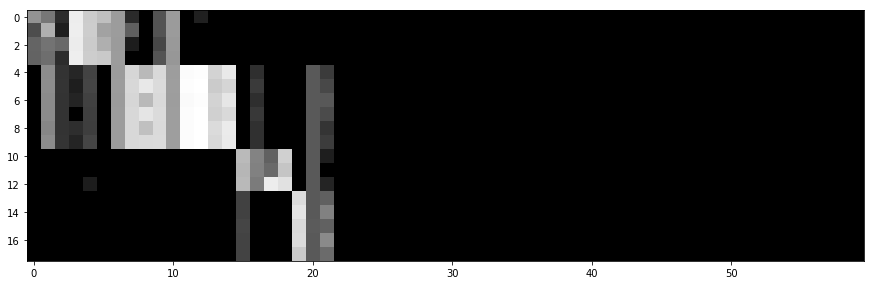

In [8]:
Z = z
A = np.zeros((np.shape(LB)[1],np.shape(Z)[1]))

# Compute the absolute value of correlation between each source factor and each latent variable
for i in range(np.shape(LB)[1]):
    
    si = np.absolute(LB[:,i])
    mu_si = np.mean(si)
    for j in range(np.shape(Z)[1]):
        zj = np.absolute(Z[:,j])
        mu_zj = np.mean(zj)
        Sij = np.sum((si-mu_si)*(zj-mu_zj))/(np.shape(si)[0]-1)
        
        m = si*zj
        v = Sij/(np.std(si)*np.std(zj)+0.000001)
        A[i,j] = v

Af = np.absolute(A)+0.000001
Af[Af<0.07] = 0.000001 # Threshold to set to zero very small correlations (needed to order them in groups)
as1 = np.mean(Af,0)
As = np.ones((np.shape(A)[0],1))*as1

mval = np.amax(Af/As,axis=0)
mind = np.argmax(Af/As,axis=0)

mind[mval<=1] = 18

Ao = []
Ao = np.expand_dims(Ao,0)
Ao = np.repeat(Ao,18,axis=0)

# Order the latent variables such that latent variables displaying the highest correlation with the same source feature are together
for i in range(18):
    
    Ai = Af[:,mind==i]
    Ao = np.concatenate((Ao,Ai),axis=1)
    
Az = np.zeros((np.shape(A)[0],np.shape(A)[1]-np.shape(Ao)[1]))
Ao = np.concatenate((Ao,Az),axis=1)

# Plot the absolute value of correlation matrix (y axis is source features LB and x axis is latent variables z)
plt.figure(figsize=(15, 6))
plt.imshow(Ao, cmap="gray")

We can test reconstruction by decoding the sparse latent codes z to re-generate the images

In [9]:
# Reconstruct the images by decoding the latent codes
mu_x, sig_x = VSC_model.decode(z,np.shape(x_data_test),params,"stored_weights/smiley_example/VSC_stored_weights.ckpt") # Returns means and standard deviations of the reconstructed images

INFO:tensorflow:Restoring parameters from stored_weights/smiley_example/VSC_stored_weights.ckpt


lienar_projections: 2019-06-14 11:49:12,059 - DEBUG - Initialised Graph


Now visualise the resulting reconstructions by plotting some original images, latent codes and reconstructed images

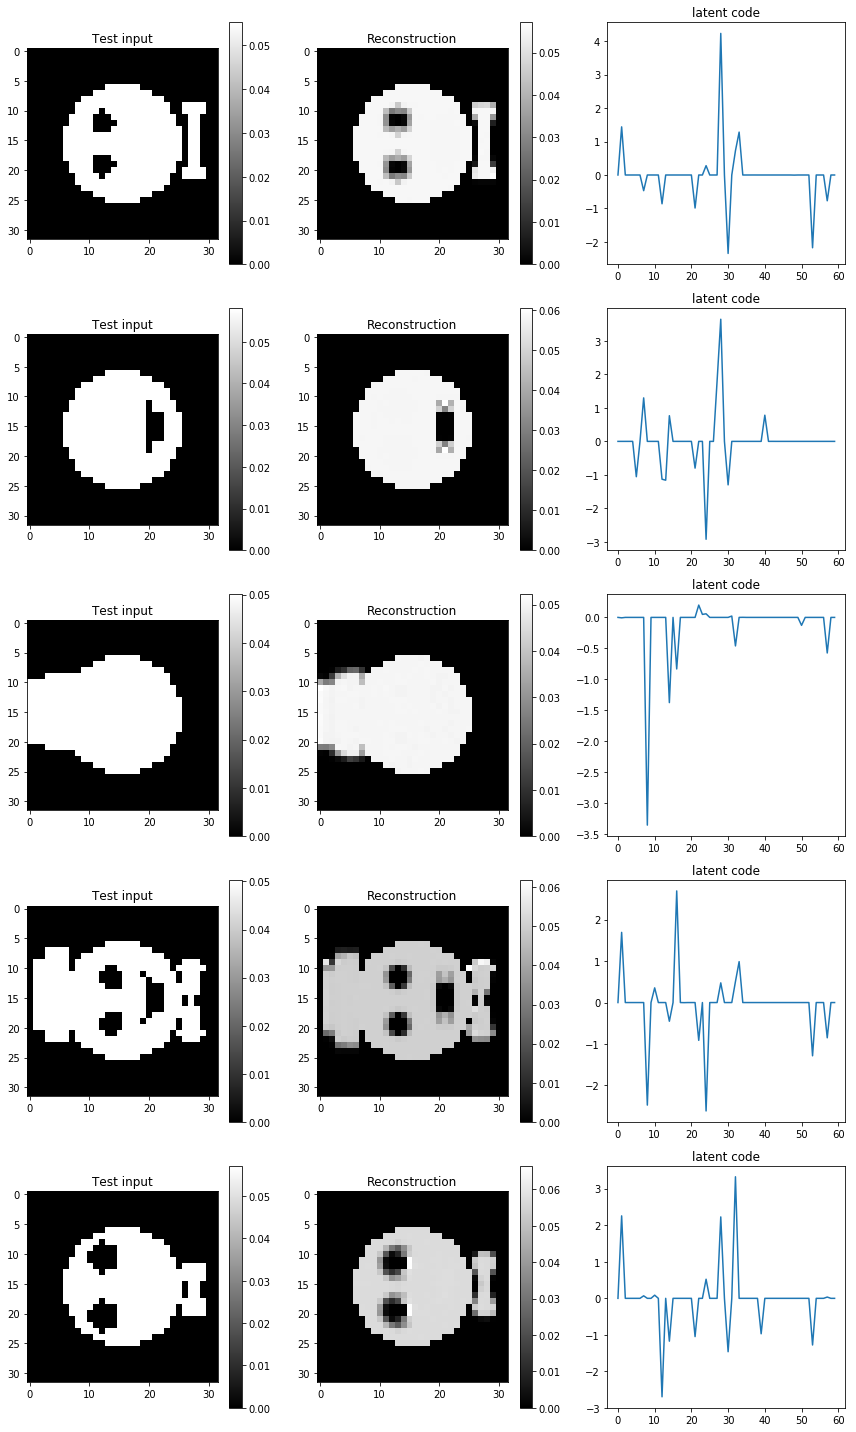

In [10]:
num_plots = 5
plt.figure(figsize=(20, 20))
for i in range(num_plots):
    
    plt.subplot(num_plots, 5, 5 * i + 1)
    plt.imshow(x_data_test[i].reshape(32, 32), cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    
    plt.subplot(num_plots, 5, 5 * i + 2)
    plt.imshow(mu_x[i].reshape(32, 32), cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
    plt.subplot(num_plots, 5, 5 * i + 3)
    plt.plot(z[i])
    plt.title("latent code")
    
plt.tight_layout()
plt.show()